## Assignment 2 | NLP | Alireza Rafiei

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from collections import defaultdict
import random
from gensim.models import Word2Vec
from textblob import TextBlob
from sklearn.metrics import accuracy_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import FunctionTransformer
import warnings
warnings.filterwarnings('ignore')


In [2]:
# load and print the data
train_data = pd.read_csv('fallreports_2023-9-21_train.csv')
test_data = pd.read_csv('fallreports_2023-9-21_test.csv')
train_data.head(10)

,record_id,redcap_repeat_instrument,gender,race,ethnicity,education,age_at_enrollment,pd_duration,num_falls_6_mo,previous_falls,...,location_binary,fall_description,fall_class,fog_yn,fall_desc_repeat,aime2023_dataset,last_followup,fall_total,fall_rate,category
0,66,Fall Report,Male,White,Not Hispanic or Latino,Completed college,60,2.4,None,non-faller,...,No,The patient was hiking. He tripped on an expos...,BoS (slips / trips),No,No,Yes,378,1,0.002646,train
1,28,Fall Report,Male,White,Not Hispanic or Latino,Completed college,56,8.0,3 or more,faller,...,Yes,The patient was reaching forward for his phone...,CoM (self-induced or externally-applied),No,No,No,402,231,0.574627,train
2,57,Fall Report,Male,White,Not Hispanic or Latino,Completed graduate degree,69,2.7,None,non-faller,...,No,The patient was digging a hole to plant an aza...,BoS (slips / trips),No,No,Yes,394,8,0.020305,train
3,39,Fall Report,Male,White,Not Hispanic or Latino,Completed graduate degree,76,9.7,3 or more,faller,...,Yes,The patient was walking towards the kitchen ta...,CoM (self-induced or externally-applied),No,No,Yes,96,480,5.000000,train
4,55,Fall Report,Male,White,Not Hispanic or Latino,Completed graduate degree,56,9.8,1,faller,...,No,The patient was home playing catch in backyard...,"Unclassifiable (falls from bed, sports-related...",No,No,Yes,391,2,0.005115,train
5,42,Fall Report,Female,White,Not Hispanic or Latino,Completed college,72,19.7,1,faller,...,No,The patient was playing pickleball. She began ...,"Unclassifiable (falls from bed, sports-related...",No,No,Yes,379,13,0.034301,train
6,696,Fall Report,Male,White,Not Hispanic or Latino,Completed graduate degree,63,63.3,3 or more,faller,...,Yes,The patient was in his closet trying to reach ...,BoS (slips / trips),No,No,No,178,25,0.140449,train
7,67,Fall Report,Female,White,Not Hispanic or Latino,Completed college,61,7.6,3 or more,faller,...,Yes,The patient fell in her closet when she lost b...,CoM (self-induced or externally-applied),No,No,No,158,24,0.151899,train
8,44,Fall Report,Female,African American/Black,Not Hispanic or Latino,Completed high school,67,10.0,1,faller,...,Yes,The patient was coming in from a walk and her ...,CoM (self-induced or externally-applied),No,No,Yes,382,2,0.005236,train
9,28,Fall Report,Male,White,Not Hispanic or Latino,Completed college,56,8.0,3 or more,faller,...,Yes,The patient was exiting the kitchen into the d...,BoS (slips / trips),No,No,No,402,231,0.574627,train


In [3]:
# data preprocessing
def preprocess_text(text):
    
    if isinstance(text, str):  # Check if the input is a string
        # Step 1: Convert text to lowercase
        text_lower = text.lower()

        # Step 2: Remove punctuation
        text_no_punct = ''.join([char for char in text_lower if char not in string.punctuation])

        # Step 3: Tokenize the lowercased text
        tokens = word_tokenize(text_no_punct)

        # Step 4: Remove stop words
        stop_words = set(stopwords.words('english'))
        filtered_tokens = [word for word in tokens if word not in stop_words]

        # Step 5: Perform stemming
        stemmer = PorterStemmer()
        stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
        
        # Combine stemmed tokens back into a string
        preprocessed_text = ' '.join(stemmed_tokens)
        
        return preprocessed_text
    
    else: return text

train_set_processed = train_data.copy()
test_set_processed = test_data.copy()
train_set_processed['fall_description'] = train_data['fall_description'].apply(preprocess_text)
test_set_processed['fall_description'] = test_data['fall_description'].apply(preprocess_text)

In [4]:
# drop records with no fall description
train_set_processed.dropna(subset=['fall_description'], inplace=True)  
test_set_processed.dropna(subset=['fall_description'], inplace=True)  
train_set_processed = train_set_processed.reset_index().drop(['index'], axis = 1)
test_set_processed = test_set_processed.reset_index().drop(['index'], axis = 1)

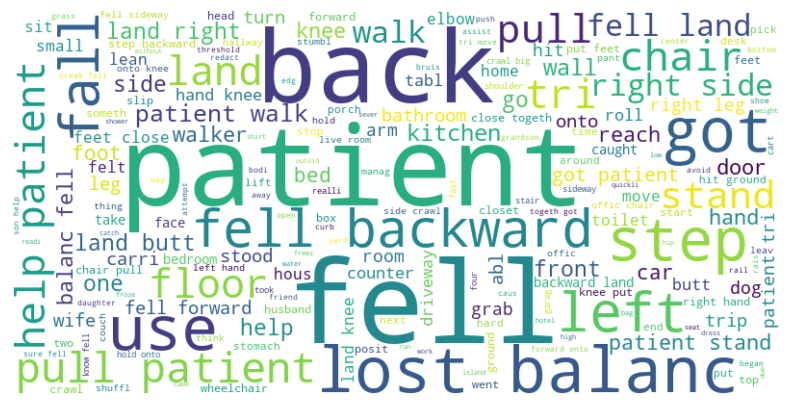

In [93]:
# set a random seed
random.seed(5)
# Concatenate preprocessed text into one string
all_train_preprocessed_text = ' '.join(train_set_processed['fall_description'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_train_preprocessed_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [5]:
# make other features ready for further analysis - I did not use these features for ML model develoment
categorical_features = ['gender', 'race', 'ethnicity', 'education', 'num_falls_6_mo', 'previous_falls', 'mds_updrs_iii_binary', 
                     'mds_updrs_iii_hy_video', 'fall_location', 'location_binary', 'fall_class', 'fog_yn', 'fall_desc_repeat', 'aime2023_dataset']


# Convert each categorical column to its integer encoding
for col in categorical_features:
    train_set_processed[col] = train_set_processed[col].astype('category').cat.codes
    test_set_processed[col] = test_set_processed[col].astype('category').cat.codes

# label - data split
train_label = train_set_processed['fog_q_class']
test_label = test_set_processed['fog_q_class']

train_set_processed_v2 = train_set_processed.drop(['fog_q_class'], axis = 1)
test_set_processed_v2 = test_set_processed.drop(['fog_q_class'], axis = 1)

selected_features = ['fall_description'] 
train_selected_features = train_set_processed_v2[selected_features]
test_selected_features = test_set_processed_v2[selected_features]

train_set_text = train_set_processed_v2['fall_description'] 
test_set_text = test_set_processed_v2['fall_description'] 

In [ ]:
# n-gram 1-3 feature extraction
vectorizer = CountVectorizer(ngram_range=(1, 3), max_features=1000)
train_set_vectorized = vectorizer.fit_transform(train_selected_features['fall_description'])
test_set_vectorized = vectorizer.transform(test_selected_features['fall_description'])

In [15]:
# extract the lenght of texts as a feature set
def text_length(texts):
    return np.array([len(text) for text in texts]).reshape(-1, 1)

X_train_length = text_length(train_set_text)
X_test_length = text_length(test_set_text)

In [ ]:
# TD IDF as a feature set

vectorizer2 = TfidfVectorizer(ngram_range=(1, 3), max_features=1000)
train_set_vectorized2 = vectorizer2.fit_transform(train_selected_features['fall_description'])
test_set_vectorized2 = vectorizer2.transform(test_selected_features['fall_description'])

In [7]:
# extract LDA as a feature set
from sklearn.decomposition import LatentDirichletAllocation

n_topics_lda = 2 # number of topics
lda = LatentDirichletAllocation(n_components=n_topics_lda, random_state=42)
lda_train = lda.fit_transform(train_set_vectorized2)
lda_test = lda.transform(test_set_vectorized2)

In [14]:
# sentiment score as a feature set
def extract_sentiment_scores(sentences):
    sentiment_scores = []
    for sentence in sentences:
        blob = TextBlob(sentence)
        sentiment_scores.append([blob.polarity, blob.subjectivity])
    return np.array(sentiment_scores)

X_train_sentiment = extract_sentiment_scores(train_set_text)
X_test_sentiment = extract_sentiment_scores(test_set_text)

In [10]:
# apply word cluster technique
word_clusters = {}

def loadwordclusters():
    infile = open('./50mpaths2')
    for line in infile:
        items = str.strip(line).split()
        class_ = items[0]
        term = items[1]
        word_clusters[term] = class_
    return word_clusters

def getclusterfeatures(sent):
    terms = nltk.word_tokenize(sent)
    cluster_string = ''
    for t in terms:
        if t in word_clusters.keys():
                cluster_string += 'clust_' + word_clusters[t] + '_clust '
    return str.strip(cluster_string)

word_clusters = loadwordclusters()

test_clusters = []
training_clusters = []

for tr in train_set_text:
    training_clusters.append(getclusterfeatures(tr))
for tt in test_set_text:
    test_clusters.append(getclusterfeatures(tt))

clustervectorizer = CountVectorizer(ngram_range=(1,3), max_features=1000)

training_cluster_vectors = clustervectorizer.fit_transform(training_clusters).toarray()
test_cluster_vectors = clustervectorizer.transform(test_clusters).toarray()

In [11]:
# generate Word2Vec vectors for sentences
def sentence_vector(sentence, model):
    vectors = []
    for word in sentence:
        try:
            vectors.append(model.wv[word])
        except KeyError:
            continue
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)


tokenized_w2v_train = [sentence.split() for sentence in train_set_text]
tokenized_w2v_test = [sentence.split() for sentence in test_set_text]

model_w2v = Word2Vec(tokenized_w2v_train, vector_size=100, window=5, min_count=1, sg=0)

X_train_w2v = np.array([sentence_vector(sentence, model_w2v) for sentence in tokenized_w2v_train])
X_test_w2v = np.array([sentence_vector(sentence, model_w2v) for sentence in tokenized_w2v_test])

In [56]:
# develop a BiLSTM model as the feature extractor
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Flatten,Bidirectional, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras import backend as K

y_train_one_hot = to_categorical(train_label, num_classes=2)
y_test_one_hot = to_categorical(test_label, num_classes=2)

tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(pd.DataFrame(train_set_text))
sequences = tokenizer.texts_to_sequences(train_set_text)
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

# create and train the model
input_layer = Input(shape=(100,))
embedding = Embedding(input_dim=10000, output_dim=64)(input_layer)
bilstm1 = Bidirectional(LSTM(units=64, return_sequences = True, recurrent_dropout=0.2))(embedding)
bilstm2 = Bidirectional(LSTM(units=64, return_sequences = True, recurrent_dropout=0.2))(bilstm1)
flat = Flatten()(bilstm2)
dense = Dense(16, activation='relu')(flat)
output_layer = Dense(2, activation='sigmoid')(dense)  # Assuming binary classification
lstm_model = Model(inputs=input_layer, outputs=output_layer)
lstm_model.summary()

# compile the model
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
lstm_model.fit(padded_sequences, y_train_one_hot, epochs=200, batch_size=32)

# save the model
lstm_model.save("trained_bilstm_model.h5")

# evaluate the performance of the model
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(pd.DataFrame(test_set_text))
sequences = tokenizer.texts_to_sequences(test_set_text)
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

y_pred = lstm_model.predict(padded_sequences)
print("Accuracy:", accuracy_score(np.argmax(y_test_one_hot, axis=1), np.argmax(y_pred, axis=1)))

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 100, 64)           640000    
                                                                 
 bidirectional_10 (Bidirecti  (None, 100, 128)         66048     
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 100, 128)         98816     
 onal)                                                           
                                                                 
 flatten_5 (Flatten)         (None, 12800)             0         
                                                                 
 dense_10 (Dense)            (None, 16)                2048

In [8]:
# load the saved model
from tensorflow.keras.models import load_model

loaded_lstm_model = load_model("trained_bilstm_model.h5")

In [ ]:
# extract features from the developed BiLSTM model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(pd.DataFrame(train_set_text))
sequences = tokenizer.texts_to_sequences(train_set_text)
padded_sequences_train = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(pd.DataFrame(test_set_text))
sequences = tokenizer.texts_to_sequences(test_set_text)
padded_sequences_test = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

# create a feature extraction model based on the loaded model
feature_model = Model(inputs=loaded_lstm_model.input, outputs=loaded_lstm_model.layers[-2].output)

# extract features using the loaded model
bilstm_train = feature_model.predict(padded_sequences_train)
bilstm_test = feature_model.predict(padded_sequences_test)

# save the extracted features
np.save('bilstm_train.npy' , bilstm_train)
np.save('bilstm_test.npy' , bilstm_test)


3/3 [==============================] - 0s 81ms/step


In [9]:
# load the extracted features
bilstm_train = np.load('bilstm_train.npy')
bilstm_test = np.load('bilstm_test.npy')

In [38]:
# BERT feature extractor
from transformers import BertTokenizer, BertModel
import torch

# Initialize BERT model and tokenizer
bert_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to get BERT embeddings
def get_bert_embedding(sentence):
    inputs = tokenizer(sentence, padding=True, truncation=True, max_length=100, return_tensors="pt")
    outputs = bert_model(**inputs)
    # Use the BERT representation of the `[CLS]` token as sentence embedding
    sentence_embedding = outputs.last_hidden_state[:, 0, :].detach().numpy()
    return sentence_embedding

# extract features
bert_train = np.array([get_bert_embedding(text) for text in train_set_text]).squeeze()
bert_test = np.array([get_bert_embedding(text) for text in test_set_text]).squeeze()

# save the extracted features
np.save('bert_train.npy', bert_train)
np.save('bert_test.npy', bert_test)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
# load the BERT extracted feature set
bert_train = np.load('bert_train.npy')
bert_test = np.load('bert_test.npy')

In [ ]:
# concatinate all the feature sets
train_set = np.hstack((train_set_vectorized.toarray(),train_set_vectorized2.toarray(),training_cluster_vectors,X_train_length, X_train_sentiment,X_train_w2v,bert_train,lda_train,bilstm_train ))
test_set = np.hstack((test_set_vectorized.toarray(),test_set_vectorized2.toarray(),test_cluster_vectors,X_test_length,X_test_sentiment,X_test_w2v,bert_test,lda_test,bilstm_test))

In [27]:
# initialize classifiers
classifiers = {
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0) 
}

# train classifiers and print evaluation metrics
for name, clf in classifiers.items():
    # train classifier
    clf.fit(train_set, train_label)
    
    # make predictions
    y_pred = clf.predict(test_set)
    
    # calculate metrics
    acc = accuracy_score(test_label, y_pred)
    f1_micro = f1_score(test_label, y_pred, average='micro')
    f1_macro = f1_score(test_label, y_pred, average='macro')
    
    # print metrics
    print(f"Classifier: {name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Micro-averaged F1 score: {f1_micro:.4f}")
    print(f"Macro-averaged F1 score: {f1_macro:.4f}")
    print('-' * 40)

Classifier: Naive Bayes
Accuracy: 0.6812
Micro-averaged F1 score: 0.6812
Macro-averaged F1 score: 0.6795
----------------------------------------
Classifier: SVM
Accuracy: 0.5362
Micro-averaged F1 score: 0.5362
Macro-averaged F1 score: 0.5338
----------------------------------------
Classifier: Logistic Regression
Accuracy: 0.7391
Micro-averaged F1 score: 0.7391
Macro-averaged F1 score: 0.7378
----------------------------------------
Classifier: Random Forest
Accuracy: 0.7101
Micro-averaged F1 score: 0.7101
Macro-averaged F1 score: 0.7071
----------------------------------------
Classifier: XGBoost
Accuracy: 0.6667
Micro-averaged F1 score: 0.6667
Macro-averaged F1 score: 0.6664
----------------------------------------
Classifier: LightGBM
Accuracy: 0.6667
Micro-averaged F1 score: 0.6667
Macro-averaged F1 score: 0.6667
----------------------------------------


In [17]:
# define a grid search using 5-fild cross validation on the train set
def search_hyperparam_space(params, classifier, x_train, y_train, x_val, y_val):
    grid = GridSearchCV(estimator=classifier, param_grid=params, refit=True, cv=5, return_train_score=False, scoring='f1_micro')
    grid.fit(x_train, y_train)
    return grid.cv_results_

In [ ]:
# initialize k fold
skf = StratifiedKFold(n_splits=5)

classifiers = {
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0)  # Turn off verbose output
}

param_grids = {
    'SVM': {'C': [0.01,0.1, 1, 5, 10, 100], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 'random_state': [1]},
    'Logistic Regression': {'C': [0.01,0.1, 1, 5, 10, 100], 'penalty': ['none', 'l2'], 'solver': ['liblinear', 'lbfgs'], 'random_state': [1]},
    'Random Forest': {'n_estimators': [50, 100, 200, 500], 'max_depth': [None, 5, 10, 12, 20], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2, 4], 'random_state': [1]},
    'XGBoost': {'learning_rate': [0.01, 0.1], 'n_estimators': [50, 100, 200, 500], 'max_depth': [3, 5, 10, 12], 'random_state': [1]},
    'LightGBM': {'learning_rate': [0.01, 0.1], 'n_estimators': [50, 100, 200, 500], 'max_depth': [3, 5, 10, 12], 'random_state': [1]},
    'CatBoost': {'learning_rate': [0.01, 0.1], 'iterations': [50, 100, 200], 'depth': [3, 5, 10], 'random_state': [1]}
}


for name, param_grid in param_grids.items():
    all_results = []
    for train_index, valid_index in skf.split(train_selected_features, train_label):

        vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=1000, stop_words='english')
        X_train = vectorizer.fit_transform(train_selected_features['fall_description']).toarray()
        X_train = np.hstack((X_train, train_selected_features.drop(['fall_description'],axis=1)))

        train_set_ = X_train[train_index]
        valid_set_ = X_train[valid_index]
    
        y_train_, y_valid_ = train_label[train_index], train_label[valid_index]
    
        cv_results = search_hyperparam_space(param_grid, classifiers[name], train_set_, y_train_, valid_set_, y_valid_)
        all_results.append(cv_results)

    # initialize dictionaries to aggregate results.
    param_sums = defaultdict(float)
    param_counts = defaultdict(int)

    # aggregate the results across all folds.
    for fold_result in all_results:
        means = fold_result['mean_test_score']
        params = fold_result['params']
        for mean, param in zip(means, params):
            param_str = str(param)
            param_sums[param_str] += mean
            param_counts[param_str] += 1

    # compute the average f1_micro score for each parameter setting.
    param_avgs = {param: total_sum / param_counts[param] for param, total_sum in param_sums.items()}

    # find the parameter setting with the highest average f1_micro score.
    best_param = max(param_avgs, key=param_avgs.get)
    print(f"Best parameter setting across all folds for {classifiers[name]}: {best_param}")
    print('-' * 40)

In [40]:
# run the fine-tuned classifiers
classifiers = {
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(C = 5, kernel = 'linear', random_state = 1),
    'Logistic Regression': LogisticRegression(solver = 'liblinear', random_state = 1),
    'Random Forest': RandomForestClassifier(max_depth = 10, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200, random_state = 1),
    'XGBoost': XGBClassifier(learning_rate = 0.1, max_depth = 12, n_estimators = 500, random_state = 1),
    'LightGBM': LGBMClassifier(learning_rate = 0.01, max_depth = 3, n_estimators = 200, random_state = 1),
    'CatBoost': CatBoostClassifier(learning_rate = 0.01, iterations = 100 , depth =10, verbose=0, random_state = 1) 
}

# train classifiers and print evaluation metrics
for name, clf in classifiers.items():
    # train classifier
    clf.fit(train_set, train_label)
    
    # make predictions
    y_pred = clf.predict(test_set)
    
    # calculate metrics
    acc = accuracy_score(test_label, y_pred)
    f1_micro = f1_score(test_label, y_pred, average='micro')
    f1_macro = f1_score(test_label, y_pred, average='macro')
    
    # print metrics
    print(f"Classifier: {name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Micro-averaged F1 score: {f1_micro:.4f}")
    print(f"Macro-averaged F1 score: {f1_macro:.4f}")
    print('-' * 40)

Classifier: Naive Bayes
Accuracy: 0.6957
Micro-averaged F1 score: 0.6957
Macro-averaged F1 score: 0.6933
----------------------------------------
Classifier: SVM
Accuracy: 0.7101
Micro-averaged F1 score: 0.7101
Macro-averaged F1 score: 0.7096
----------------------------------------
Classifier: Logistic Regression
Accuracy: 0.7246
Micro-averaged F1 score: 0.7246
Macro-averaged F1 score: 0.7237
----------------------------------------
Classifier: Random Forest
Accuracy: 0.7246
Micro-averaged F1 score: 0.7246
Macro-averaged F1 score: 0.7225
----------------------------------------
Classifier: XGBoost
Accuracy: 0.6957
Micro-averaged F1 score: 0.6957
Macro-averaged F1 score: 0.6957
----------------------------------------
Classifier: LightGBM
Accuracy: 0.6377
Micro-averaged F1 score: 0.6377
Macro-averaged F1 score: 0.6349
----------------------------------------
Classifier: CatBoost
Accuracy: 0.6522
Micro-averaged F1 score: 0.6522
Macro-averaged F1 score: 0.6394
---------------------------

In [19]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


# initialize individual models
svm_clf = SVC(C = 5, kernel = 'linear', random_state = 1)
lr_clf = LogisticRegression(solver = 'liblinear', random_state = 1)
rf_clf = RandomForestClassifier(max_depth = 10, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200, random_state = 1)

# create an ensemble of the models using majority class voting
ensemble_clf = VotingClassifier(estimators=[
    ('random_forest', rf_clf),
    ('svm', svm_clf),
    ('logistic_regression', lr_clf)
], voting='hard')  # 'hard' for majority class voting

# fit the ensemble model on the training data
ensemble_clf.fit(train_set , train_label)

# make predictions on the test data
y_pred = ensemble_clf.predict(test_set)

# calculate micro and macro averaged F1 scores
acc = accuracy_score(test_label, y_pred)
f1_micro = f1_score(test_label, y_pred, average='micro')
f1_macro = f1_score(test_label, y_pred, average='macro')
print(f"Accuracy: {acc:.4f}")
print(f"Micro-averaged F1 score: {f1_micro:.4f}")
print(f"Macro-averaged F1 score: {f1_macro:.4f}")

Accuracy: 0.7246
Micro-averaged F1 score: 0.7246
Macro-averaged F1 score: 0.7237


### Training set size versus performance analysis

In [70]:
acc_a = []
f1_micro_a = []
f1_macro_a = []

for i in np.arange(0.1, 1.1, 0.01):
    len_ = len(train_set_text)*i

    train_set_text2 = train_set_text.copy()
    test_set_text2 = test_set_text.copy()
    train_label2 =train_label.copy()

    train_set_text2 = train_set_text2[:int(len_)]
    train_label2 = train_label[:int(len_)]

    X_train_length = text_length(train_set_text2)
    X_test_length = text_length(test_set_text2)

    vectorizer = CountVectorizer(ngram_range=(1, 3), max_features=1000)
    train_set_vectorized = vectorizer.fit_transform(train_set_text2)
    test_set_vectorized = vectorizer.transform(test_set_text2)

    vectorizer2 = TfidfVectorizer(ngram_range=(1, 3), max_features=1000)
    train_set_vectorized2 = vectorizer2.fit_transform(train_set_text2)
    test_set_vectorized2 = vectorizer2.transform(test_set_text2)

    lda = LatentDirichletAllocation(n_components=n_topics_lda, random_state=42)
    lda_train = lda.fit_transform(train_set_vectorized2)
    lda_test = lda.transform(test_set_vectorized2)

    word_clusters = {}

    word_clusters = loadwordclusters()

    test_clusters = []
    training_clusters = []

    for tr in train_set_text2:
        training_clusters.append(getclusterfeatures(tr))
    for tt in test_set_text2:
        test_clusters.append(getclusterfeatures(tt))

    clustervectorizer = CountVectorizer(ngram_range=(1,3), max_features=1000)

    training_cluster_vectors = clustervectorizer.fit_transform(training_clusters).toarray()
    test_cluster_vectors = clustervectorizer.transform(test_clusters).toarray()



    X_train_sentiment = extract_sentiment_scores(train_set_text2)
    X_test_sentiment = extract_sentiment_scores(test_set_text2)

    tokenized_w2v_train = [sentence.split() for sentence in train_set_text2]
    tokenized_w2v_test = [sentence.split() for sentence in test_set_text2]

    model_w2v = Word2Vec(tokenized_w2v_train, vector_size=100, window=5, min_count=1, sg=0)

    X_train_w2v = np.array([sentence_vector(sentence, model_w2v) for sentence in tokenized_w2v_train])
    X_test_w2v = np.array([sentence_vector(sentence, model_w2v) for sentence in tokenized_w2v_test])

    train_set2 = np.hstack((train_set_vectorized.toarray(),train_set_vectorized2.toarray(),training_cluster_vectors,X_train_length, lda_train, X_train_sentiment,X_train_w2v)) #
    test_set2 = np.hstack((test_set_vectorized.toarray(),test_set_vectorized2.toarray(),test_cluster_vectors,X_test_length,lda_test, X_test_sentiment,X_test_w2v)) #


    clf = RandomForestClassifier(max_depth = 10, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200, random_state = 1)


    # train classifier
    clf.fit(train_set2, train_label2)
    
    # make predictions
    y_pred = clf.predict(test_set2)
    
    # calculate metrics
    acc = accuracy_score(test_label, y_pred)
    f1_micro = f1_score(test_label, y_pred, average='micro')
    f1_macro = f1_score(test_label, y_pred, average='macro')

    acc_a.append(acc)
    f1_micro_a.append(f1_micro)
    f1_macro_a.append(f1_macro)

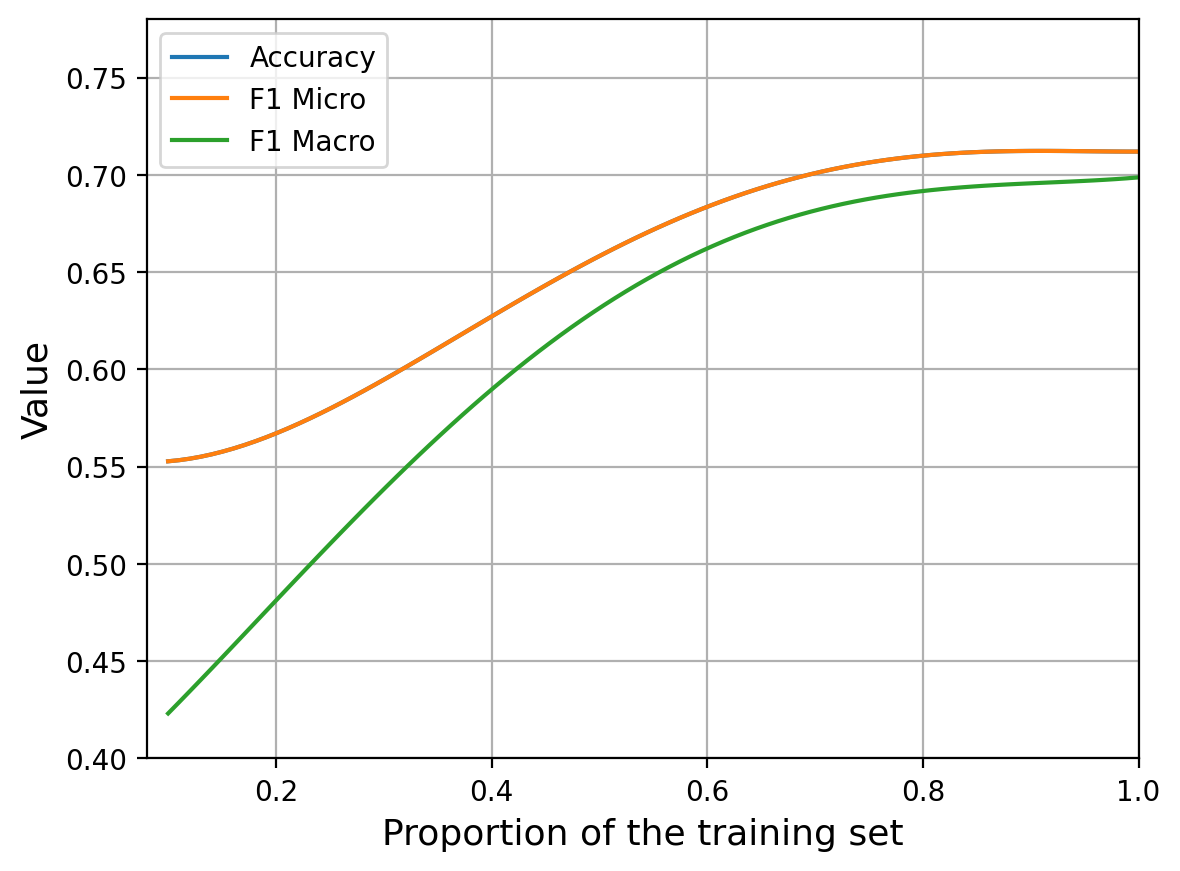

In [82]:
import matplotlib.pyplot as plt
# original x-values
x = np.arange(0.1, 1.1, 0.01)

# polynomial fitting
degree = 4  # Degree of the polynomial 
coefficients_acc = np.polyfit(x, acc_a, degree)
polynomial_acc = np.poly1d(coefficients_acc)

coefficients_mi = np.polyfit(x, f1_micro_a, degree)
polynomial_mi = np.poly1d(coefficients_mi)

coefficients_ma = np.polyfit(x, f1_macro_a, degree)
polynomial_ma = np.poly1d(coefficients_ma)

# generate new x values for plotting the smooth curve
x_new = np.linspace(0.1, 1.1, 100)
y_acc = polynomial_acc(x_new)
y_mi = polynomial_mi(x_new)
y_ma = polynomial_ma(x_new)

plt.figure(dpi = 200)
# plotting
plt.plot(x_new, y_acc, '-', label='Accuracy', )
plt.plot(x_new, y_mi, '-', label='F1 Micro')
plt.plot(x_new, y_ma, '-', label='F1 Macro')
plt.xlabel('Proportion of the training set', fontsize = 13)
plt.ylabel('Value', fontsize = 13)
plt.xlim(0.08,1.0)
plt.ylim(0.40,0.78)
plt.legend()
plt.grid(True)
plt.show()

### Ablation study

In [96]:
# remove BiLSTM and BERT feature sets from the input features and run the best-performing model
train_set = np.hstack((train_set_vectorized.toarray(),train_set_vectorized2.toarray(),training_cluster_vectors,X_train_length, X_train_sentiment,X_train_w2v,lda_train)) 
test_set = np.hstack((test_set_vectorized.toarray(),test_set_vectorized2.toarray(),test_cluster_vectors,X_test_length,X_test_sentiment,X_test_w2v,lda_test)) 

clf = RandomForestClassifier(max_depth = 10, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200, random_state = 1)

# train classifier
clf.fit(train_set, train_label)
    
# make predictions
y_pred = clf.predict(test_set)
    
# calculate metrics
acc = accuracy_score(test_label, y_pred)
f1_micro = f1_score(test_label, y_pred, average='micro')
f1_macro = f1_score(test_label, y_pred, average='macro')

print(f"Accuracy: {acc:.4f}")
print(f"Micro-averaged F1 score: {f1_micro:.4f}")
print(f"Macro-averaged F1 score: {f1_macro:.4f}")

Accuracy: 0.7391
Micro-averaged F1 score: 0.7391
Macro-averaged F1 score: 0.7295


In [98]:
# remove BiLSTM, BERT and LDA feature sets from the input features and run the best-performing model
train_set = np.hstack((train_set_vectorized.toarray(),train_set_vectorized2.toarray(),training_cluster_vectors,X_train_length, X_train_sentiment,X_train_w2v))
test_set = np.hstack((test_set_vectorized.toarray(),test_set_vectorized2.toarray(),test_cluster_vectors,X_test_length,X_test_sentiment,X_test_w2v))

clf = RandomForestClassifier(max_depth = 10, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200, random_state = 1)

# train classifier
clf.fit(train_set, train_label)
    
# make predictions
y_pred = clf.predict(test_set)
    
# calculate metrics
acc = accuracy_score(test_label, y_pred)
f1_micro = f1_score(test_label, y_pred, average='micro')
f1_macro = f1_score(test_label, y_pred, average='macro')

print(f"Accuracy: {acc:.4f}")
print(f"Micro-averaged F1 score: {f1_micro:.4f}")
print(f"Macro-averaged F1 score: {f1_macro:.4f}")

Accuracy: 0.7536
Micro-averaged F1 score: 0.7536
Macro-averaged F1 score: 0.7430


In [99]:
# remove BiLSTM, BERT and LDA, and word2vec feature sets from the input features and run the best-performing model
train_set = np.hstack((train_set_vectorized.toarray(),train_set_vectorized2.toarray(),training_cluster_vectors,X_train_length, X_train_sentiment)) 
test_set = np.hstack((test_set_vectorized.toarray(),test_set_vectorized2.toarray(),test_cluster_vectors,X_test_length,X_test_sentiment)) 

clf = RandomForestClassifier(max_depth = 10, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200, random_state = 1)

# train classifier
clf.fit(train_set, train_label)
    
# make predictions
y_pred = clf.predict(test_set)
    
# calculate metrics
acc = accuracy_score(test_label, y_pred)
f1_micro = f1_score(test_label, y_pred, average='micro')
f1_macro = f1_score(test_label, y_pred, average='macro')

print(f"Accuracy: {acc:.4f}")
print(f"Micro-averaged F1 score: {f1_micro:.4f}")
print(f"Macro-averaged F1 score: {f1_macro:.4f}")

Accuracy: 0.6667
Micro-averaged F1 score: 0.6667
Macro-averaged F1 score: 0.6641


In [100]:
# remove BiLSTM, BERT and LDA, word2vec and sentiment score feature sets from the input features and run the best-performing model
train_set = np.hstack((train_set_vectorized.toarray(),train_set_vectorized2.toarray(),training_cluster_vectors,X_train_length)) 
test_set = np.hstack((test_set_vectorized.toarray(),test_set_vectorized2.toarray(),test_cluster_vectors,X_test_length)) 

clf = RandomForestClassifier(max_depth = 10, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200, random_state = 1)

# train classifier
clf.fit(train_set, train_label)
    
# make predictions
y_pred = clf.predict(test_set)
    
# calculate metrics
acc = accuracy_score(test_label, y_pred)
f1_micro = f1_score(test_label, y_pred, average='micro')
f1_macro = f1_score(test_label, y_pred, average='macro')

print(f"Accuracy: {acc:.4f}")
print(f"Micro-averaged F1 score: {f1_micro:.4f}")
print(f"Macro-averaged F1 score: {f1_macro:.4f}")

Accuracy: 0.6957
Micro-averaged F1 score: 0.6957
Macro-averaged F1 score: 0.6891


In [101]:
# remove BiLSTM, BERT and LDA, word2vec, sentiment score, and text_length feature sets from the input features and run the best-performing model
train_set = np.hstack((train_set_vectorized.toarray(),train_set_vectorized2.toarray(),training_cluster_vectors)) 
test_set = np.hstack((test_set_vectorized.toarray(),test_set_vectorized2.toarray(),test_cluster_vectors)) 

clf = RandomForestClassifier(max_depth = 10, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200, random_state = 1)

# train classifier
clf.fit(train_set, train_label)
    
# make predictions
y_pred = clf.predict(test_set)
    
# calculate metrics
acc = accuracy_score(test_label, y_pred)
f1_micro = f1_score(test_label, y_pred, average='micro')
f1_macro = f1_score(test_label, y_pred, average='macro')

print(f"Accuracy: {acc:.4f}")
print(f"Micro-averaged F1 score: {f1_micro:.4f}")
print(f"Macro-averaged F1 score: {f1_macro:.4f}")

Accuracy: 0.6522
Micro-averaged F1 score: 0.6522
Macro-averaged F1 score: 0.6431


In [102]:
# remove BiLSTM, BERT and LDA, word2vec, sentiment score,text_length and word cluster feature sets from the input features and run the best-performing model
train_set = np.hstack((train_set_vectorized.toarray(),train_set_vectorized2.toarray())) 
test_set = np.hstack((test_set_vectorized.toarray(),test_set_vectorized2.toarray())) 

clf = RandomForestClassifier(max_depth = 10, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200, random_state = 1)

# train classifier
clf.fit(train_set, train_label)
    
# make predictions
y_pred = clf.predict(test_set)
    
# calculate metrics
acc = accuracy_score(test_label, y_pred)
f1_micro = f1_score(test_label, y_pred, average='micro')
f1_macro = f1_score(test_label, y_pred, average='macro')

print(f"Accuracy: {acc:.4f}")
print(f"Micro-averaged F1 score: {f1_micro:.4f}")
print(f"Macro-averaged F1 score: {f1_macro:.4f}")

Accuracy: 0.6812
Micro-averaged F1 score: 0.6812
Macro-averaged F1 score: 0.6756


In [104]:
# remove BiLSTM, BERT and LDA, word2vec, sentiment score,text_length, word cluster, and TF IDF feature sets from the input features and run the best-performing model
train_set = train_set_vectorized.toarray()
test_set = test_set_vectorized.toarray()

clf = RandomForestClassifier(max_depth = 10, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200, random_state = 1)

# train classifier
clf.fit(train_set, train_label)
    
# make predictions
y_pred = clf.predict(test_set)
    
# calculate metrics
acc = accuracy_score(test_label, y_pred)
f1_micro = f1_score(test_label, y_pred, average='micro')
f1_macro = f1_score(test_label, y_pred, average='macro')

print(f"Accuracy: {acc:.4f}")
print(f"Micro-averaged F1 score: {f1_micro:.4f}")
print(f"Macro-averaged F1 score: {f1_macro:.4f}")

Accuracy: 0.6957
Micro-averaged F1 score: 0.6957
Macro-averaged F1 score: 0.6891
